# Create a model to predict active power for a set of Wind Turbines

In [526]:
# setup environment
import requests
import configparser
import json
import pandas as pd
from datetime import date, timedelta
from ocs_sample_library_preview import *
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import re
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from seaborn import pairplot
import statsmodels.api as ssm #for detail description of linear coefficients, intercepts, deviations, and many more
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

get_ipython().magic(u'config IPCompleter.greedy=True')

In [472]:
# Configure access to OSIsoft Cloud Services (OCS) environment
config = configparser.ConfigParser()
config.read('..\..\config_prod_osisoft-events.ini')
#config.read('config.ini')

ocsClient = OCSClient(config.get('Access', 'ApiVersion'), config.get('Access', 'Tenant'), config.get('Access', 'Resource'), 
                        config.get('Credentials', 'ClientId'), config.get('Credentials', 'ClientSecret'))

namespaceId = config.get('Configurations', 'Namespace')

In [473]:
# check we are in the namespace we expect to be!
namespaceId

'Production'

In [486]:
# retrieve a dataset from OCS
dateFrom = '2020-01-15'
#dateTo ='2020-01-26'
dateTo = '2020-01-20'
dateFrom='2020-01-20'
dateTo='2020-01-24'
#dateFrom='2020-01-24'
#dateTo='2020-01-26'
# dateFrom = str(date.today()-timedelta(days=10))
# dateTo = str(date.today()) #10 days of data
timeinterval = '00:05:00' #interpolate every minute

#dataviewId = Wind Turbine Data_NN, where NN is your specific student number (e.g. NN=01 in this example)
if namespaceId == "Production":
    dataviewId= "Wind Turbine Data"
else:
    dataviewId= "Wind Turbine Data_SOLUTION"

ocsClient.request_timeout = 2000
data = ocsClient.DataViews.getDataInterpolated(namespaceId, dataviewId, startIndex=dateFrom, endIndex=dateTo, 
                                                         interval=timeinterval, count=150000)

# perform data preparation on the dataset

In [ ]:
# # if data retrieved in batches, join it together
# len(data1[0])+len(data2[0])+len(data3[0])
# data = []
# data.extend(data1[0])
# data.extend(data2[0])
# data.extend(data3[0])
len(data)

In [498]:
dataview = data

In [500]:
# create a dataframe from the query response
df = pd.DataFrame(dataview)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index(df['Timestamp'],inplace=True)
df.drop(columns='Timestamp',inplace=True)
compression=dict(method='zip',archive_name='turbines.csv')
df.to_csv("turbines.zip",compression=compression)
df.to_csv("turbines.csv")
print(f'rows: {len(df)}')
df = df.rename(columns=lambda x: re.sub(' Value.*$','',x))
df

rows: 31710


,Turbine,Blade1 Actual,Blade2 Actual,Blade3 Actual,Rotor Speed,State,Active Power,Nacelle Position,Air Temperature,Wind Speed
Timestamp,,,,,,,,,,
2020-01-15 00:00:00+00:00,GE01,0.07,0.20,0.20,12.26,16,153.49,42.26,53.26,5.49
2020-01-15 00:05:00+00:00,GE01,0.08,0.20,0.20,12.37,16,61.65,41.28,53.32,4.83
2020-01-15 00:10:00+00:00,GE01,0.08,0.20,0.20,12.48,16,107.48,36.28,53.38,4.66
2020-01-15 00:15:00+00:00,GE01,0.08,0.20,0.20,12.59,16,203.54,34.22,53.44,6.46
2020-01-15 00:20:00+00:00,GE01,0.08,0.20,0.20,12.69,16,229.68,34.88,53.49,6.03
...,...,...,...,...,...,...,...,...,...,...
2020-01-25 23:40:00+00:00,GE10,-0.19,-0.20,0.45,12.58,16,100.77,27.53,56.08,5.14
2020-01-25 23:45:00+00:00,GE10,-0.19,-0.21,0.44,13.02,16,260.56,29.55,56.10,7.16
2020-01-25 23:50:00+00:00,GE10,-0.19,-0.21,0.43,12.59,16,197.58,33.72,56.12,5.15


In [519]:
# view count of events by day
df.groupby(df.index.day).count()
#.plot(kind="bar") # add to previous command to display histogram

,Turbine,Blade1 Actual,Blade2 Actual,Blade3 Actual,Rotor Speed,State,Active Power,Nacelle Position,Air Temperature,Wind Speed
Timestamp,,,,,,,,,,
15,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880
16,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880
17,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880
18,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880
19,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880
20,2890,2890,2890,2890,2890,2890,2890,2890,2890,2890
21,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880
22,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880
23,2880,2880,2880,2880,2880,2880,2880,2880,2880,2880


In [507]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31710 entries, 2020-01-15 00:00:00+00:00 to 2020-01-26 00:00:00+00:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Turbine           31710 non-null  object 
 1   Blade1 Actual     31710 non-null  float64
 2   Blade2 Actual     31710 non-null  float64
 3   Blade3 Actual     31710 non-null  float64
 4   Rotor Speed       31710 non-null  float64
 5   State             31710 non-null  int64  
 6   Active Power      31710 non-null  float64
 7   Nacelle Position  31710 non-null  float64
 8   Air Temperature   31710 non-null  float64
 9   Wind Speed        31710 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.7+ MB


# explore dataset

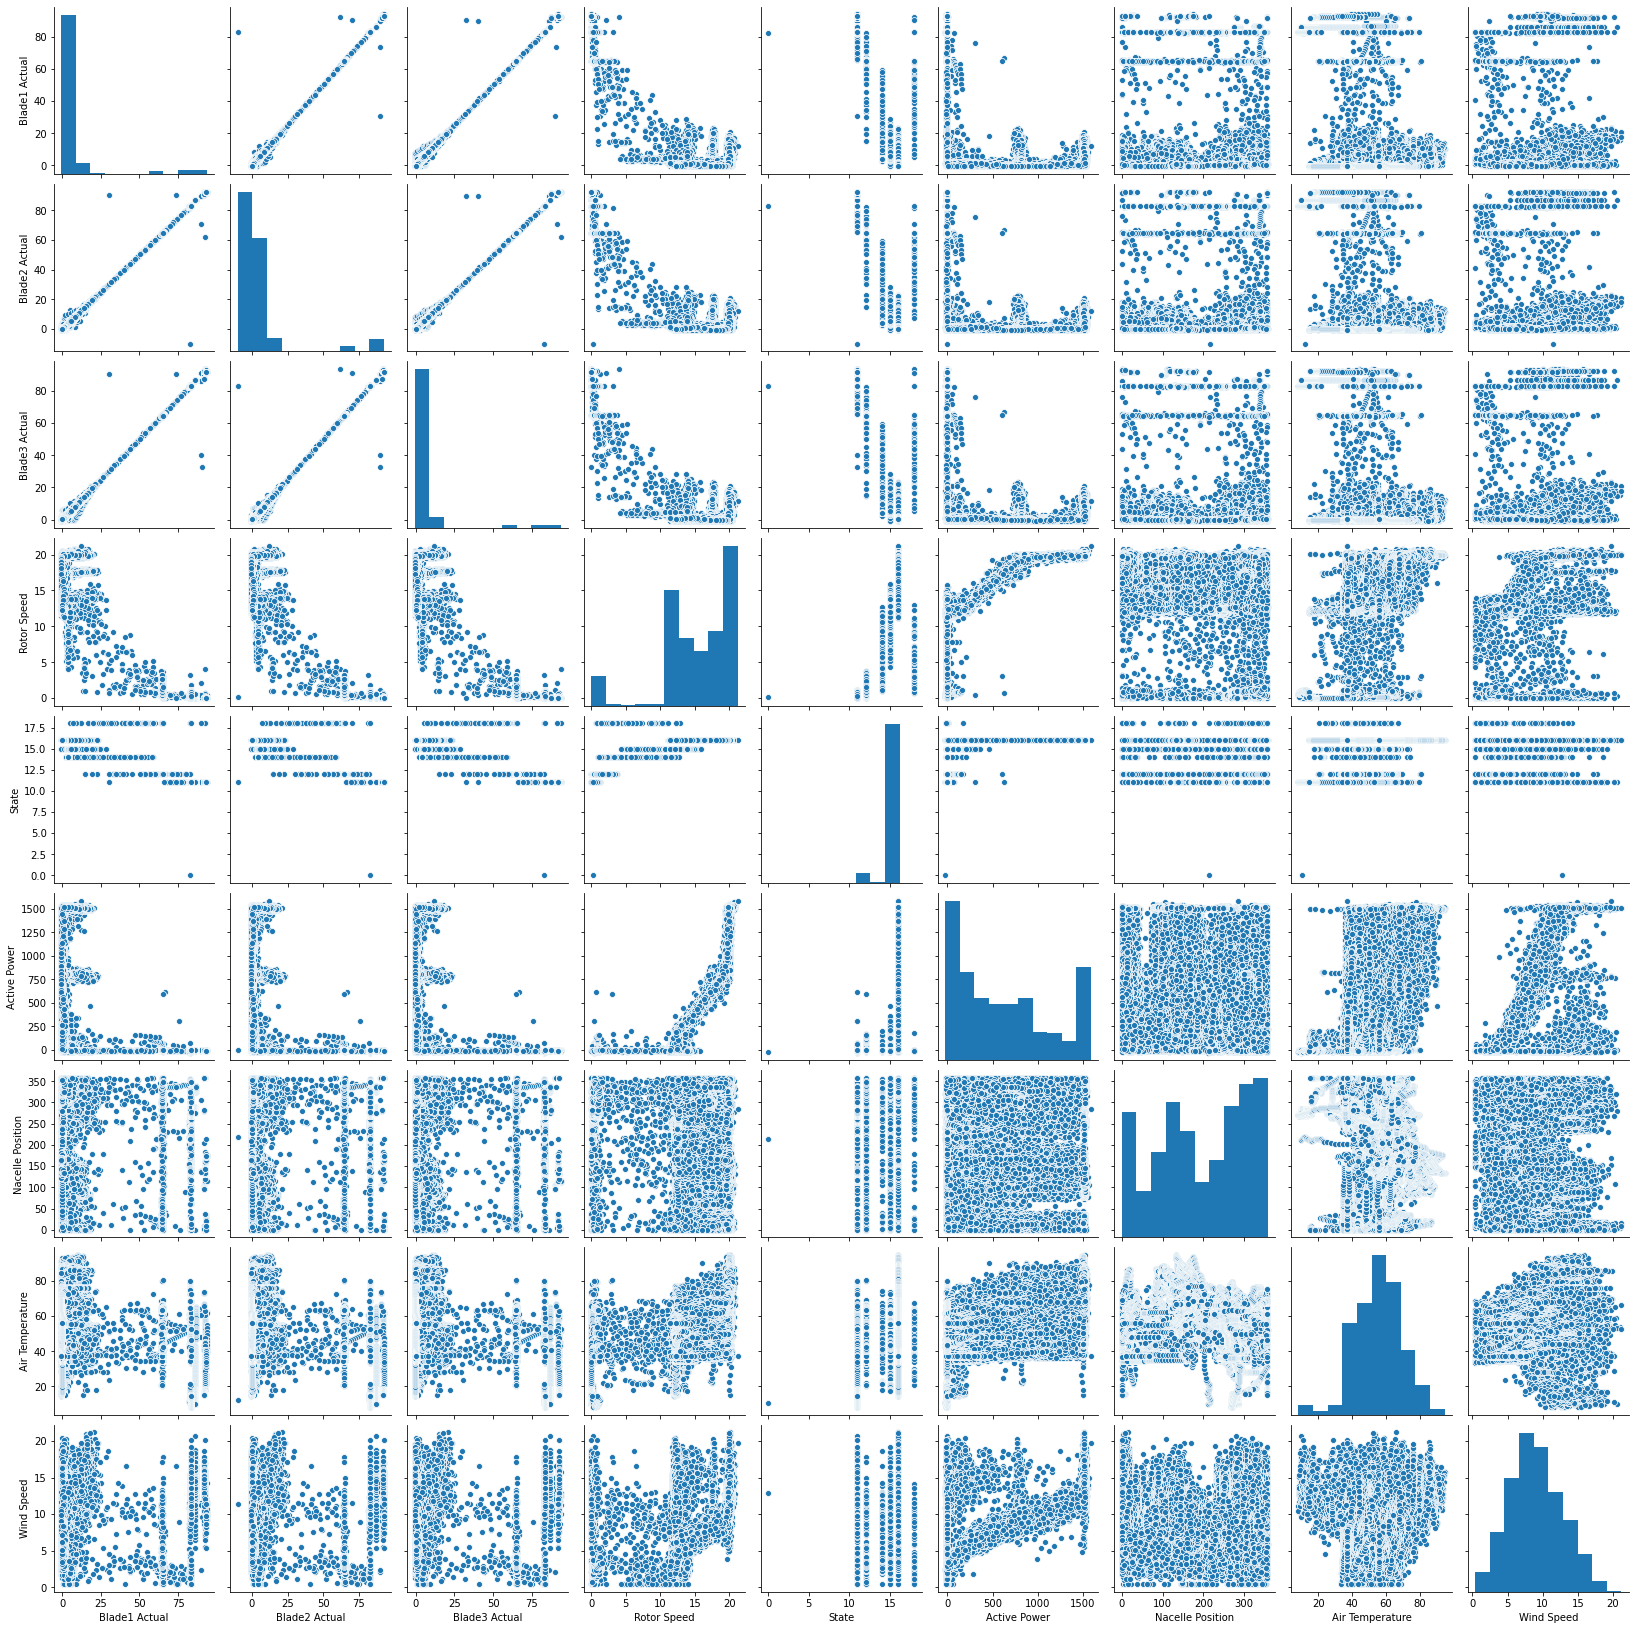

In [521]:
# visualize relationship between measures
pairplot(df);

In [245]:
# Renaming DataFrame column names to abbreviations, in order to display these column names clearly in a correlation plot 

df_plot = df.copy()
df_plot.rename(columns = {'Blade1, Actual':'Blade 1', 'Blade2, Actual':'Blade 2', 
                     'Blade3, Actual':'Blade 3', 'Rotor Speed':'Rotor S.','Turbine State':'State', 
                     'Active Power':'A. Power', 'Nacelle Position':'Direction', 'Air Temperature':'Air Temp.',
                     'Wind Speed':'Wind Spd.'}, inplace = True)

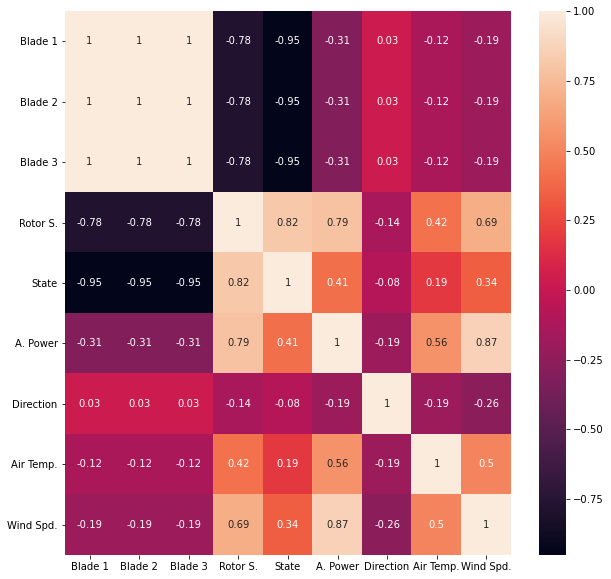

In [298]:
# Correlation plot of measurements

#increase the size of the figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# compute the pair wise correlation for all columns  
correlation_matrix = df_plot.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True,);
_ = plt.yticks(rotation=0)

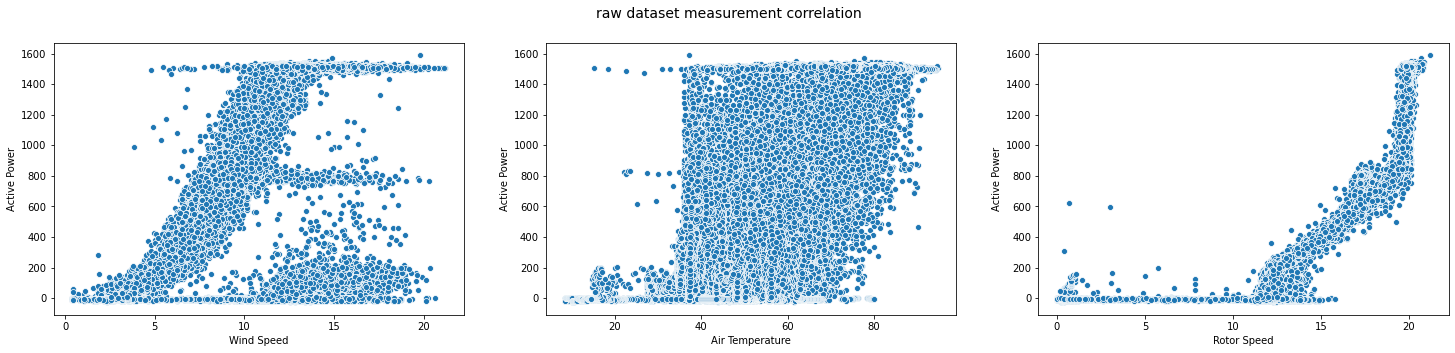

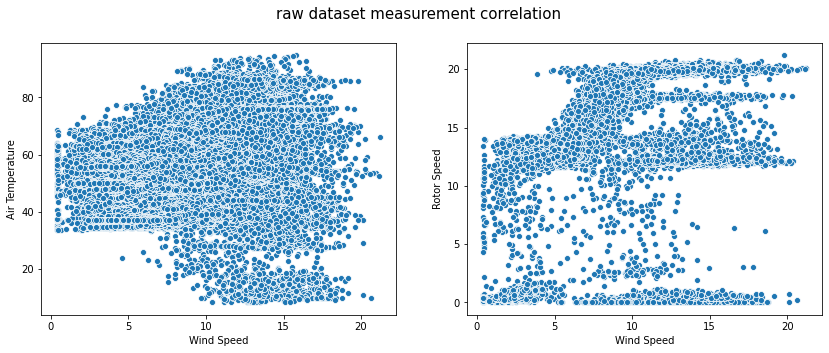

In [540]:
# explore dataset for correlation between dependent variable (what we are trying to predict) and potential features

def plot_scatter(df,title=None):
    dependent = "Active Power"
    feature1 = "Wind Speed"
    feature2 = "Air Temperature"
    feature3 = "Rotor Speed"

    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(25,5))

    sns.scatterplot(df[feature1], df[dependent],ax=ax1)
    sns.scatterplot(df[feature2], df[dependent],ax=ax2)
    sns.scatterplot(df[feature3], df[dependent],ax=ax3)

    fig2, (ax4,ax5) = plt.subplots(1,2,figsize=(14,5))

    sns.scatterplot(df[feature1], df[feature2],ax=ax4)
    sns.scatterplot(df[feature1], df[feature3],ax=ax5);
    
    if title:
        fig.suptitle(title, fontsize=14)
        fig2.suptitle(title, fontsize=15)
    
plot_scatter(df,"raw dataset measurement correlation")

# data preparation

In [509]:
#Remove the GE05 turbine rows from the data frame because it has a lower rating relative to all the other turbines
filterOutGE05 = df['Turbine'] != "GE05"
df_Filter = df[filterOutGE05]

In [510]:
#Filter out negative & excessive Active Power Values
filterNegativeActivePower = (df_Filter['Active Power'] >= 0) 
df_Filter = df_Filter[filterNegativeActivePower]

In [511]:
#Remove the rows where we have a high wind speed and low active power in order to keep only the normal operating conditions
filterOutLowPowerHighWindSpeedData = (~((df_Filter['Wind Speed'] >  10) & (df_Filter['Active Power'] <600)))
df_Filter = df_Filter[filterOutLowPowerHighWindSpeedData]

In [514]:
#Keep only the rows which correspond to the "Load Operation" state
filterLoadOperationState = df_Filter['State'] == 16
df_Filter = df_Filter[filterLoadOperationState]

In [515]:
#Filter out high Wind Speeds (> 13 m/s) that do not change the Active Power results
filterOutHighWind = df_Filter['Wind Speed'] <13
df_Filter = df_Filter[filterOutHighWind]

# visualiaze datasets from pre-post data preparation

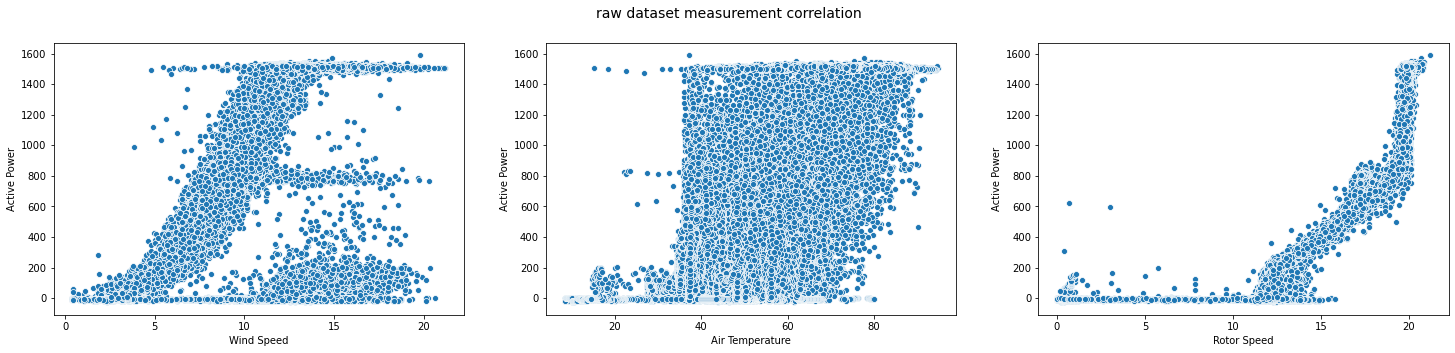

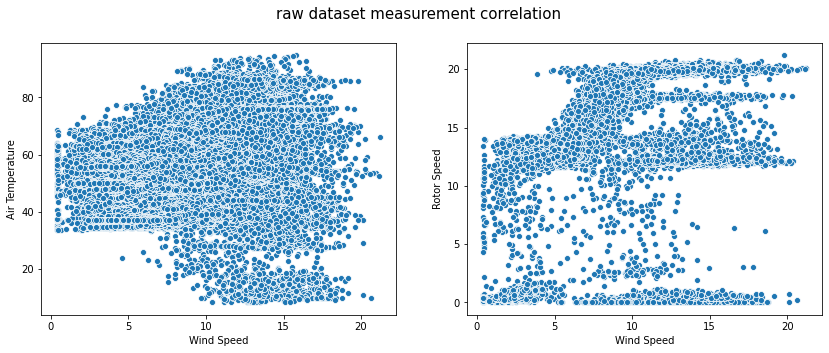

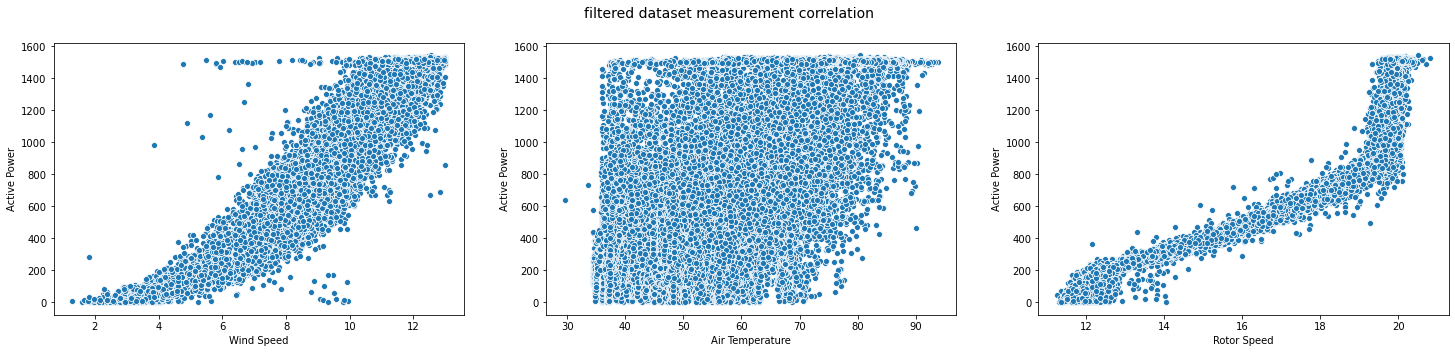

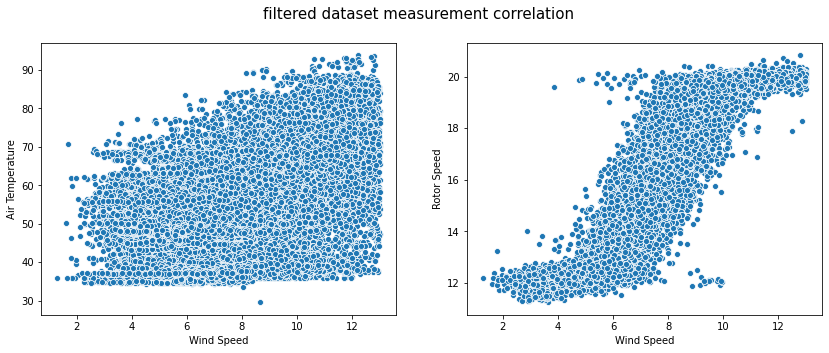

In [541]:
#Plotting Active Power versus Wind Speed - filtered data frame representing Normal Operating Conditions
plot_scatter(df,"raw dataset measurement correlation")
plot_scatter(df_Filter,"filtered dataset measurement correlation")

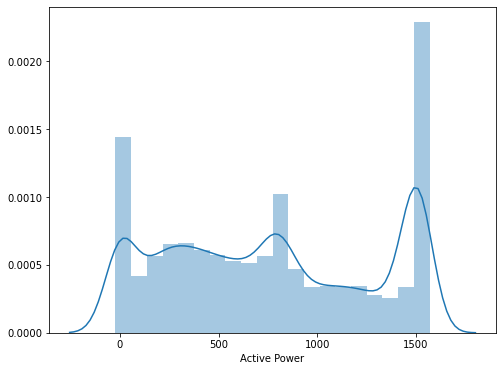

In [326]:
# histogram of target values indicate data is not representitive of a normal distribution, i.e.: non-parametric which may influence model selection
fig = plt.figure(figsize=(8,6))
sns.distplot(df['Active Power'],bins=20);

# create models

## split data for training and testing

In [586]:
#Prepare the training & testing/scoring data sets, and split them randomly

#define the target variable to be predicted
y = df_Filter['Active Power'].values
#split the dataset randomly into test and train sets
X_train, X_test, y_train, y_test = train_test_split(df_Filter[['Air Temperature', 'Wind Speed']].values, 
                                                     y, test_size=0.25, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df_Filter[['Wind Speed']].values, 
#                                                     y, test_size=0.25, random_state=42)


### polynomial regression model

In [587]:
# create function to create a polynomial regression model based upon recommendations from various scientific papers including: https://www.hindawi.com/journals/jen/2016/8519785
# function below care of Animesh Agarwal:
# https://towardsdatascience.com/polynomial-regression-bbe8b9d97491
# https://github.com/animesh-agarwal/Machine-Learning-Datasets/blob/master/boston-housing/Polynomial_Regression.ipynb

def create_polynomial_regression_model(degree):
  "Creates a polynomial regression model for the given degree"
  poly_features = PolynomialFeatures(degree=degree)
  
  # transform the features to higher degree features.
  X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  
  # predicting on training data-set
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  r2_train = r2_score(y_train, y_train_predicted)
  
  # evaluating the model on test dataset
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
  r2_test = r2_score(y_test, y_test_predict)
  
  print("The model performance for the training set")
  print("-------------------------------------------")
  print("RMSE of training set is {}".format(rmse_train))
  print("R2 score of training set is {}".format(r2_train))
  
  print("\n")
  
  print("The model performance for the test set")
  print("-------------------------------------------")
  print("RMSE of test set is {}".format(rmse_test))
  print("R2 score of test set is {}".format(r2_test))
  
  return poly_model

In [588]:
# create 3 models with different degrees
degree = 4  # specify which level of degree we are going to use. 4 = "quartic"
_ = create_polynomial_regression_model(2)
_ = create_polynomial_regression_model(3)
turbine_model = create_polynomial_regression_model(degree)

The model performance for the training set
-------------------------------------------
RMSE of training set is 135.5310964193228
R2 score of training set is 0.911322584684383


The model performance for the test set
-------------------------------------------
RMSE of test set is 135.36634473055548
R2 score of test set is 0.9121376523954138
The model performance for the training set
-------------------------------------------
RMSE of training set is 130.99493385622893
R2 score of training set is 0.917159230820059


The model performance for the test set
-------------------------------------------
RMSE of test set is 130.42261334765155
R2 score of test set is 0.9184381260411001
The model performance for the training set
-------------------------------------------
RMSE of training set is 129.54246900559747
R2 score of training set is 0.9189861142377487


The model performance for the test set
-------------------------------------------
RMSE of test set is 128.55778835074298
R2 score of te

In [589]:
# sample prediction
new_input = [[45, 6.6]] #Temp=45 F, Wind Speed = 6.6 m/s

poly_features = PolynomialFeatures(degree=degree)
turbine_model.predict(poly_features.fit_transform(new_input))

array([297.87831928])

In [606]:
# model parameters - coefficients and bias
InteractiveShell.ast_node_interactivity = 'all'
turbine_model.coef_
turbine_model.intercept_

array([ 0.00000000e+00, -9.85425674e+01,  3.89886034e+02,  3.01451395e+00,
       -7.44387858e+00, -7.73230413e+01, -4.26980884e-02,  1.77592588e-01,
       -5.11789741e-02,  9.91067627e+00,  2.27296031e-04, -1.23873458e-03,
        6.82454319e-04, -2.29881284e-03, -3.64297484e-01])

875.7953818013465

### decision tree regression

In [546]:
#Use the Decision Tree Regression Machine Learning model from scikit-learn
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
_ = regr_1.fit(X_train, y_train)
_ = regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

In [550]:
# sample prediction
regr_2.predict(new_input)

array([292.97431794])

### compare models

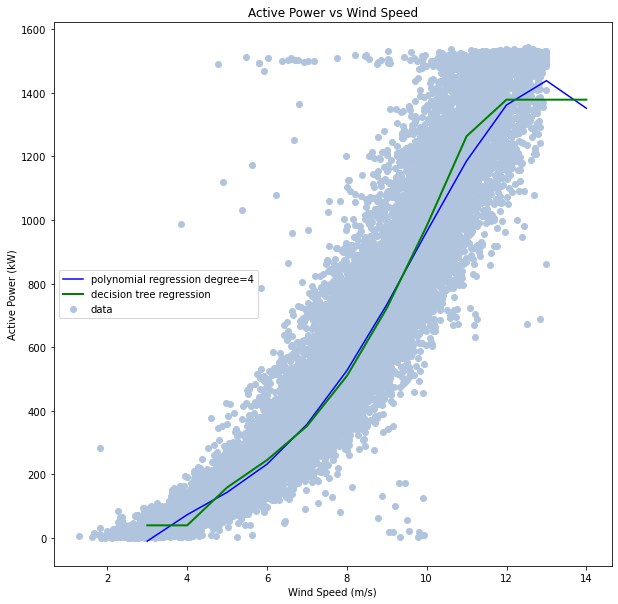

In [569]:
# plot Active Power versus Wind Speed with model predictions
# See caveat below re: air temperature

# Calculate regression line
InteractiveShell.ast_node_interactivity = 'none'
y_plot = np.empty(shape=(0)) # for predictions
x_min,x_max = 3,15  # wind speed range for plot
temp = 53.3  # static temperature - this should be resolved by creating a 3d chart to maps both features - air temp & wind speed - to active power - todo...
# create regression values from model
for speed in range(x_min,x_max):
    #print(speed,turbine_model.predict(poly_features.fit_transform([[temp,speed]])))
    y_plot = np.append(y_plot,turbine_model.predict(poly_features.fit_transform([[temp,speed]])))
x_plot = [x for x in range(x_min,x_max)]

# calculate Decision Tree Regression Machine line
y_dtree = np.empty(shape=(0))
for speed in range(x_min,x_max):
    y_dtree = np.append(y_dtree,regr_2.predict([[temp,speed]]))

# plot regression line with dataset
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(df_Filter['Wind Speed'], df_Filter['Active Power'],c='lightsteelblue',label="data")
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Active Power (kW)')
ax.set_title('Active Power vs Wind Speed')
plt.plot(x_plot,y_plot,color='blue',label=f"polynomial regression degree={degree}")
plt.plot(x_plot,y_dtree,color='green',linewidth=2,label="decision tree regression")
plt.legend()
plt.show()

### statsmodel analysis of polynomial regression model
note: different model to that created earlier

In [527]:
X=ssm.add_constant(X_train)        #to add constant value in the model
model = ssm.OLS(y_train,X).fit()   #fitting the model
predictions= model.summary()       #summary of the model
predictions

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 3.559e+04
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:58:47   Log-Likelihood:                -47396.
No. Observations:                7432   AIC:                         9.480e+04
Df Residuals:                    7429   BIC:                         9.482e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1045.0744      8.793   -118.850      0.000   -1062.312   -1027.837
x1             4.1529      0.148     28.130      0.000       3.863       4.442
x2           178.2585      0.793    224.762      0.000     176.704     179.813
==============================================================================
Omnibus:                       71.631   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.662
Skew:                           0.219   Prob(JB):                     3.72e-17
Kurtosis:                       3.230   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

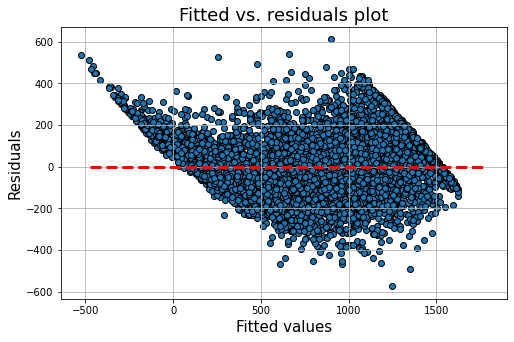

In [572]:
# compare difference between observed values (fitted) vs predicted values (residuals)

InteractiveShell.ast_node_interactivity = 'none'

plt.figure(figsize=(8,5))
p=plt.scatter(x=model.fittedvalues,y=model.resid,edgecolor='k')
xmin=min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

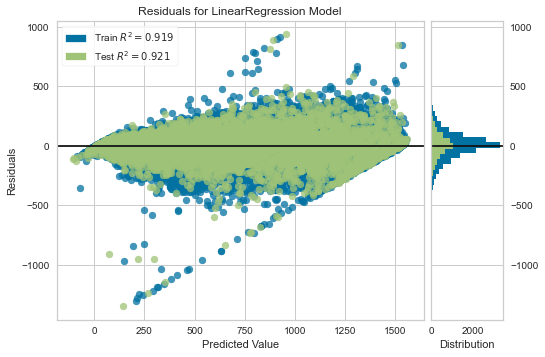

In [598]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

InteractiveShell.ast_node_interactivity = 'none'

X_train.shape
y_train.shape
X_test.shape
y_test.shape

"Creates a polynomial regression model for the given degree"
poly_features = PolynomialFeatures(degree=degree)

# transform the features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

visualizer = ResidualsPlot(LinearRegression())
#visualizer = LinearRegression(turbine_model)
visualizer.fit(X_train_poly, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_poly,y_test)  # Evaluate the model on the test data
visualizer.show()             # Finalize and render the figure

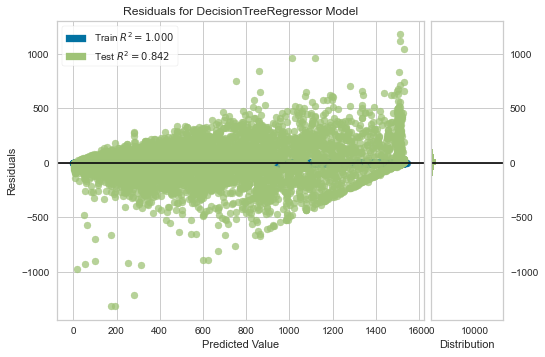

In [599]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

InteractiveShell.ast_node_interactivity = 'none'

X_train.shape
y_train.shape
X_test.shape
y_test.shape

"Creates a polynomial regression model for the given degree"
poly_features = PolynomialFeatures(degree=degree)

# transform the features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

visualizer = ResidualsPlot(DecisionTreeRegressor())
#visualizer = LinearRegression(turbine_model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test,y_test)  # Evaluate the model on the test data
visualizer.show()             # Finalize and render the figure

In [678]:
# sample prediction
new_input = [[45, 6.6]] #Temp=45 F, Wind Speed = 6.6 m/s

poly_features = PolynomialFeatures(degree=degree)
turbine_model.predict(poly_features.fit_transform(new_input))

array([297.9])

In [681]:
# explore poly regresssion model

np.set_printoptions(precision=None,suppress=True)

x_1 = poly_features.fit_transform(new_input)

model_coef = turbine_model.coef_
model_icept = turbine_model.intercept_
model_score_part1 = np.multiply(x_1,model_coef)
model_score_result = np.sum(model_score) + model_icept
model_score_result


df_man = pd.concat([pd.DataFrame(x_1).T,pd.DataFrame(model_coef),pd.DataFrame(model_score)],axis=1)
df_man
  
print(f"""
     raw values: {x_1}
     poly values: 
     {x_2}
     model coef: 
     {model_coef}
     model intercept: {model_icept}
     sum: {model_score}
     """)

718.3105626003047

,0,0,0
0,1.00,0.00,0.00
1,45.00,-98.54,"-6,199.69"
2,6.60,389.89,"3,357.25"
3,"2,025.00",3.01,"11,931.90"
4,297.00,-7.44,"-4,032.65"
5,43.56,-77.32,"-5,733.24"
6,"91,125.00",-0.04,"-10,632.78"
7,"13,365.00",0.18,"6,052.89"
8,"1,960.20",-0.05,-238.74
9,287.50,9.91,"6,327.61"



     raw values: [[      1.       45.        6.6    2025.      297.       43.6   91125.
    13365.     1960.2     287.5 4100625.   601425.    88209.    12937.3
     1897.5]]
     poly values: 
     [       1.        62.9        8.6     3958.1      541.7       74.1
   249022.3    34083.      4664.8      638.5 15666943.5  2144291.3
   293483.2    40168.2     5497.7]
     model coef: 
     [  0.  -98.5 389.9   3.   -7.4 -77.3  -0.    0.2  -0.1   9.9   0.   -0.
   0.   -0.   -0.4]
     model intercept: 875.7953818013465
     sum: [     0.   -6199.7   3357.2  11931.9  -4032.7  -5733.2 -10632.8   6052.9
   -238.7   6327.6   3561.   -2656.2    200.3    -92.3  -2002.8]
     


# Forecasting

In [22]:
#Call the OpenWeather API to retrieve the forecasted air temperature and wind speed for Amarillo, TX for the next 5 days
import requests
url="https://api.openweathermap.org/data/2.5/forecast?q=Amarillo,US&APPID=5dac981ce33f41f61d8d1ea06ee89798"
responseWeatherForecast=requests.get(url)

In [ ]:
responseWeatherForecast.json()

In [24]:
#Store the forecasted air temperature, wind speed and timestamp from the API json response in a pandas DataFrame

from decimal import Decimal
import datetime
TempArray = []
WindSpeedArray = []
TimestampArray = []

for val in responseWeatherForecast.json()["list"]:
    tempKelvin = val["main"]["temp"]
    tempF = round(((tempKelvin - 273.15) * (9/5)) + 32, 2)
    windSpeedMeterPerSec = round(val["wind"]["speed"], 2)
    np.array(TempArray.append(tempF))
    np.array(WindSpeedArray.append(windSpeedMeterPerSec))
    np.array(TimestampArray.append(datetime.datetime.strptime(val["dt_txt"], '%Y-%m-%d %H:%M:%S')))   
          
dfWeatherForecast = pd.DataFrame({'Timestamp':TimestampArray, 'Temp (F)':TempArray, 'Wind Speed (m/s)':WindSpeedArray})        
                              
dfWeatherForecast

,Timestamp,Temp (F),Wind Speed (m/s)
0,2020-03-09 21:00:00,67.69,2.62
1,2020-03-10 00:00:00,66.40,1.58
2,2020-03-10 03:00:00,57.51,4.47
3,2020-03-10 06:00:00,52.56,4.51
4,2020-03-10 09:00:00,49.08,4.64
5,2020-03-10 12:00:00,46.74,4.68
6,2020-03-10 15:00:00,52.59,5.37
7,2020-03-10 18:00:00,66.87,6.77
8,2020-03-10 21:00:00,72.10,8.60
9,2020-03-11 00:00:00,68.77,5.51


In [25]:
#Use the machine learning model developed previously to predict the Active Power and add the values to the existing Data Frame

import pickle
filename = 'WT_ActivePower_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

PredictedPowerArray=[]  

for index, row in dfWeatherForecast.iterrows():
    new_input = [[row['Temp (F)'], row['Wind Speed (m/s)']]]
    result = loaded_model.predict(new_input)
    np.array(PredictedPowerArray.append(result))
    
dfWeatherForecast['Predicted Active Power (kW)']=pd.DataFrame(PredictedPowerArray)

dfWeatherForecast

,Timestamp,Temp (F),Wind Speed (m/s),Predicted Active Power (kW)
0,2020-03-09 21:00:00,67.69,2.62,45.678394
1,2020-03-10 00:00:00,66.40,1.58,45.678394
2,2020-03-10 03:00:00,57.51,4.47,90.243342
3,2020-03-10 06:00:00,52.56,4.51,90.243342
4,2020-03-10 09:00:00,49.08,4.64,136.106125
5,2020-03-10 12:00:00,46.74,4.68,136.106125
6,2020-03-10 15:00:00,52.59,5.37,178.055281
7,2020-03-10 18:00:00,66.87,6.77,369.521367
8,2020-03-10 21:00:00,72.10,8.60,702.448600
9,2020-03-11 00:00:00,68.77,5.51,178.055281


# write results back to OSIsoft Cloud Services

In [26]:
config = configparser.ConfigParser()
config.read('config.ini')

ocsClient = OCSClient(config.get('Access', 'ApiVersion2'), config.get('Access', 'Tenant'), config.get('Access', 'Resource'), 
                        config.get('Credentials', 'ClientId'), config.get('Credentials', 'ClientSecret'))

namespaceId = config.get('Configurations', 'Namespace')

In [27]:
#SDS Type Name = Wind Turbine Predictions Time_NN, where NN is your specific student number (e.g. NN=01 in this example)

typeWindTurbinePredTimeName = "Wind Turbine Predictions Time_01"
 
    
typeWindTurbinePredTime = SdsType(id=typeWindTurbinePredTimeName, description="A Time-Series indexed type with 3 values",
        sdsTypeCode=SdsTypeCode.Object)

doubleType = SdsType()
doubleType.Id = "doubleType"
doubleType.SdsTypeCode = SdsTypeCode.Double

timeType = SdsType()
timeType.Id = "DateTimeType"
timeType.SdsTypeCode = SdsTypeCode.DateTime

airtemperature = SdsTypeProperty()
airtemperature.Id = "Air_Temperature"
airtemperature.Name =  "Air Temperature"
airtemperature.SdsType = doubleType

windspeed = SdsTypeProperty()
windspeed.Id = "Wind_Speed"
windspeed.Name =  "Wind Speed"
windspeed.SdsType = doubleType

activepower = SdsTypeProperty()
activepower.Id = "Predicted_Active_Power"
activepower.Name =  "Predicted Active Power"
activepower.SdsType = doubleType

time = SdsTypeProperty()
time.Id = "Timestamp"
time.Name = "Timestamp"
time.SdsType = timeType
time.IsKey = True

typeWindTurbinePredTime.Properties = [airtemperature, windspeed, activepower, time]

ocsClient.Types.getOrCreateType(namespaceId, typeWindTurbinePredTime)


In [28]:
#SDS Stream Id = WT_5dForecast_NN, SDS Stream Name = Wind Turbine 5 Day Forecast Data_NN, 
#where NN is your specific student number (e.g. NN=01 in this example)

StreamId = "WT_5dForecast_01"
StreamName = "Wind Turbine 5 Day Forecast Data_01"
StreamDescr = "Big Buffalo Wind Farm Forecasted Wind Speed, Air Temperature & Active Power for Next 5 Days"

In [29]:
stream = SdsStream()
stream.Id = StreamId
stream.Name = StreamName
stream.Description = StreamDescr
stream.TypeId = typeWindTurbinePredTime.Id

ocsClient.Streams.createOrUpdateStream(namespaceId, stream)

In [30]:
#Prepare the newly created OCS data stream values by looping through the dfWeatherForecast Data Frame's rows

values = []

for index, row in dfWeatherForecast.iterrows():
        values.append({"Air_Temperature": row["Temp (F)"], "Wind_Speed": row["Wind Speed (m/s)"], 
                       "Predicted_Active_Power": row["Predicted Active Power (kW)"], "Timestamp": 
                       row["Timestamp"].strftime('%Y-%m-%d %H:%M:%S') })

ocsClient.Streams.insertValues(namespaceId, stream.Id, json.dumps(values))

# Export predictions for use with PowerBI

In [79]:
predictions_2_ind = pd.DataFrame()
for speed in range(0,18):
    predictions_2_ind = predictions_2_ind.append([[regr_2.predict([[45,speed]])[0]]],ignore_index=True)

In [85]:
predictions_2_ind.rename(columns={0:"2ind"},inplace=True)

In [ ]:
predictions_2_ind

In [93]:
predictions_1_ind = pd.DataFrame()
for speed in range(0,18):
    predictions_1_ind = predictions_1_ind.append([[regr_2.predict([[speed]])[0]]],ignore_index=True)
predictions_1_ind.rename(columns={0:"1ind"},inplace=True)

In [94]:
predictions_1_ind

,1ind
0,50.728685
1,50.728685
2,50.728685
3,50.728685
4,50.728685
5,133.085487
6,265.860960
7,369.415953
8,589.771912
9,784.134500


In [106]:
df = pd.concat([predictions_1_ind,predictions_2_ind],axis=1)
df['diff'] = df['1ind'] - df['2ind']

In [116]:
pd.options.display.float_format = '{:,.2f}'.format
df

,1ind,2ind,diff
0,50.73,50.73,0.00
1,50.73,50.73,0.00
2,50.73,50.73,0.00
3,50.73,50.73,0.00
4,50.73,50.73,0.00
5,133.09,133.09,-0.00
6,265.86,265.86,-0.00
7,369.42,313.72,55.70
8,589.77,569.52,20.26
9,784.13,746.25,37.88


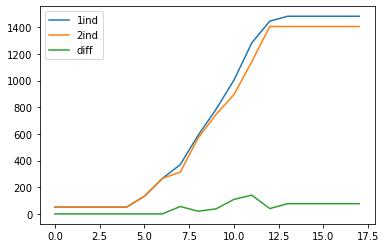

In [117]:
df.plot()

In [119]:
df.to_csv('predict.csv')